In [1]:
# !pip install git+https://github.com/Navu45/image-merging.git

In [3]:
import PIL.Image
import cv2
import numpy as np
import torch
from PIL import Image
from datasets import load_dataset
from diffusers.utils import make_image_grid, load_image
from torchvision.transforms.functional import to_pil_image
from models.inpaint_image import InpaintPipeline

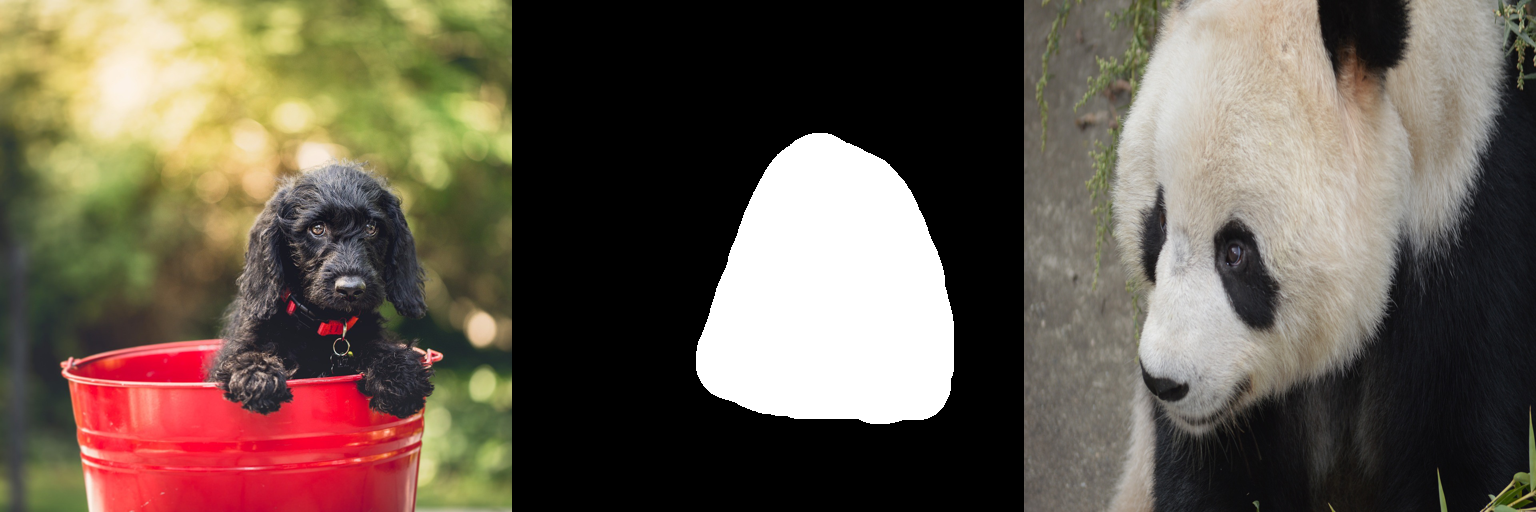

In [3]:
img_url = "https://raw.githubusercontent.com/Fantasy-Studio/Paint-by-Example/main/examples/image/example_1.png"
mask_url = "https://raw.githubusercontent.com/Fantasy-Studio/Paint-by-Example/main/examples/mask/example_1.png"
example_url = "https://raw.githubusercontent.com/Fantasy-Studio/Paint-by-Example/main/examples/reference/example_1.jpg"

dog_image = load_image(img_url).resize((512, 512))
mask_image = load_image(mask_url).resize((512, 512))
panda_image = load_image(example_url).resize((512, 512))

make_image_grid([dog_image, mask_image, panda_image], 1, 3)

In [4]:
pipe = InpaintPipeline.from_pretrained(
    'Fantasy-Studio/Paint-by-Example',
    torch_dtype=torch.float16,
    # local_files_only=True
)
pipe = pipe.to("cuda")
pipe.enable_model_cpu_offload()
pipe.enable_vae_slicing()
pipe.enable_xformers_memory_efficient_attention()

image_encoder\model.safetensors not found


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You are using a model of type clip_vision_model to instantiate a model of type clip. This is not supported for all configurations of models and can yield errors.
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


In [15]:
def generate(init_image: PIL.Image.Image, example_image: PIL.Image.Image):
    source_embeds = pipe.encode_image(init_image)
    target_embeds = pipe.encode_image(example_image)
    mask = pipe.generate_mask(init_image,
                          height=init_image.height,
                          width=init_image.width,
                          target_prompt_embeds=target_embeds,
                          source_prompt_embeds=source_embeds,
                          num_maps_per_mask=10,
                          mask_encode_strength=0.5,
                          mask_thresholding_ratio=3.0,
                          num_inference_steps=50,
                          guidance_scale=1)

    mask = to_pil_image(mask, mode='L')
    mask = Image.fromarray(cv2.medianBlur(np.asarray(mask), 99))
    image = pipe(image=init_image, mask_image=mask, example_image=example_image).images[0]
    del source_embeds, target_embeds
    torch.cuda.empty_cache()
    return image

  0%|          | 0/50 [00:00<?, ?it/s]

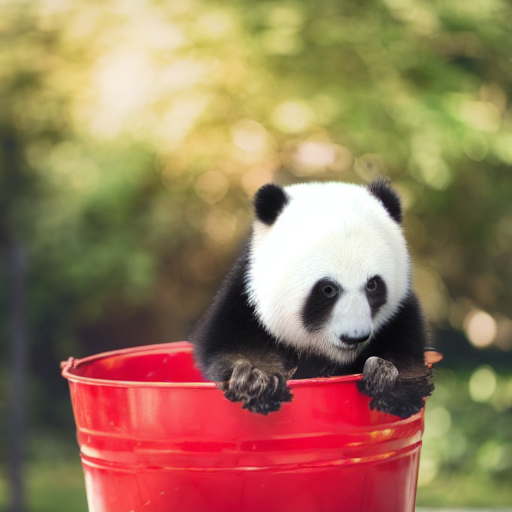

In [6]:
generate(dog_image, panda_image)

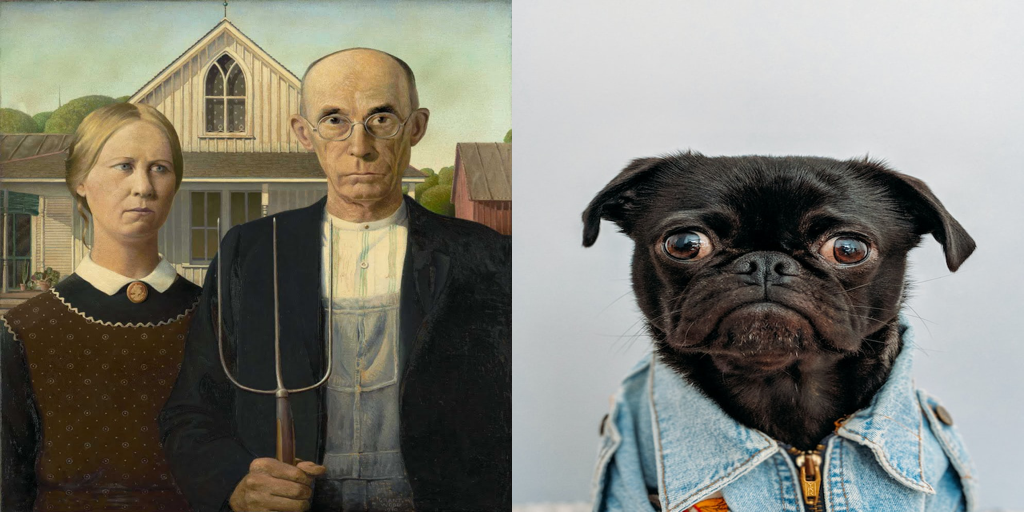

In [11]:
image1, image2 = Image.open('./data/imgs/image0.png').resize((512, 512)), Image.open('./data/imgs/image1.png').resize((512, 512))
make_image_grid([image1, image2], 1, 2)

  0%|          | 0/50 [00:00<?, ?it/s]

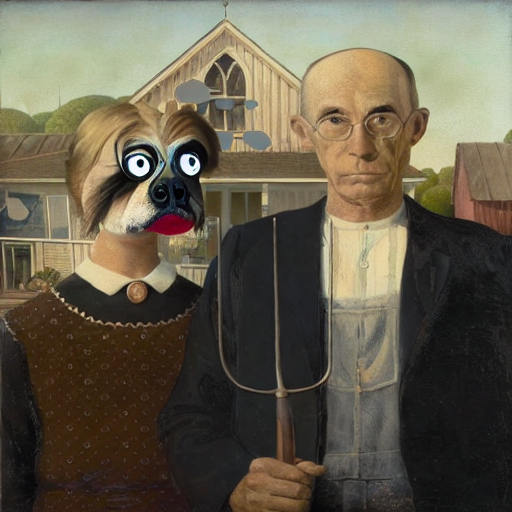

In [18]:
generate(image1, image2)